In [50]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.ar_model import AutoReg
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [51]:
census = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
test= pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv",parse_dates=['first_day_of_month'])
train=pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv",parse_dates=["first_day_of_month"])


In [52]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [53]:
for col in census.columns:
    print(col, check_outlier(census, col))

pct_bb_2017 True
pct_bb_2018 True
pct_bb_2019 True
pct_bb_2020 True
pct_bb_2021 True
cfips False
pct_college_2017 True
pct_college_2018 True
pct_college_2019 True
pct_college_2020 True
pct_college_2021 True
pct_foreign_born_2017 True
pct_foreign_born_2018 True
pct_foreign_born_2019 True
pct_foreign_born_2020 True
pct_foreign_born_2021 True
pct_it_workers_2017 True
pct_it_workers_2018 True
pct_it_workers_2019 True
pct_it_workers_2020 True
pct_it_workers_2021 True
median_hh_inc_2017 True
median_hh_inc_2018 True
median_hh_inc_2019 True
median_hh_inc_2020 True
median_hh_inc_2021 True


In [54]:
for col in census.columns:
    replace_with_thresholds(census, col)

In [55]:
census.describe().T

,count,mean,std,min,25%,50%,75%,max
pct_bb_2017,3142.000,69.999,9.468,45.900,64.200,70.700,76.400,94.600
pct_bb_2018,3142.000,72.797,8.940,50.363,67.425,73.600,78.800,95.500
pct_bb_2019,3142.000,75.531,8.451,54.150,70.500,76.450,81.400,96.000
pct_bb_2020,3141.000,78.702,7.766,59.100,74.100,79.600,84.100,97.100
pct_bb_2021,3141.000,80.713,7.352,62.150,76.400,81.700,85.900,97.600
cfips,3142.000,30383.649,15162.508,1001.000,18177.500,29176.000,45080.500,56045.000
pct_college_2017,3142.000,13.723,5.304,2.400,9.700,12.800,16.800,27.450
pct_college_2018,3142.000,13.919,5.353,0.000,9.900,13.000,17.100,27.900
pct_college_2019,3142.000,14.151,5.409,0.000,10.100,13.250,17.300,28.100
pct_college_2020,3141.000,14.548,5.517,0.000,10.500,13.600,17.900,29.000


In [56]:
census.describe().T

,count,mean,std,min,25%,50%,75%,max
pct_bb_2017,3142.000,69.999,9.468,45.900,64.200,70.700,76.400,94.600
pct_bb_2018,3142.000,72.797,8.940,50.363,67.425,73.600,78.800,95.500
pct_bb_2019,3142.000,75.531,8.451,54.150,70.500,76.450,81.400,96.000
pct_bb_2020,3141.000,78.702,7.766,59.100,74.100,79.600,84.100,97.100
pct_bb_2021,3141.000,80.713,7.352,62.150,76.400,81.700,85.900,97.600
cfips,3142.000,30383.649,15162.508,1001.000,18177.500,29176.000,45080.500,56045.000
pct_college_2017,3142.000,13.723,5.304,2.400,9.700,12.800,16.800,27.450
pct_college_2018,3142.000,13.919,5.353,0.000,9.900,13.000,17.100,27.900
pct_college_2019,3142.000,14.151,5.409,0.000,10.100,13.250,17.300,28.100
pct_college_2020,3141.000,14.548,5.517,0.000,10.500,13.600,17.900,29.000


In [57]:
drop_cols = ["pct_foreign_born_2021","pct_foreign_born_2020","pct_foreign_born_2020","pct_foreign_born_2019","pct_foreign_born_2018","pct_foreign_born_2017"]
train = train[train["microbusiness_density"]<50]
census.drop(drop_cols, inplace=True, axis=1)

In [58]:
test = pd.merge(test, census, how="left", on="cfips")
train = pd.merge(train, census, how="left", on="cfips")

<AxesSubplot:>

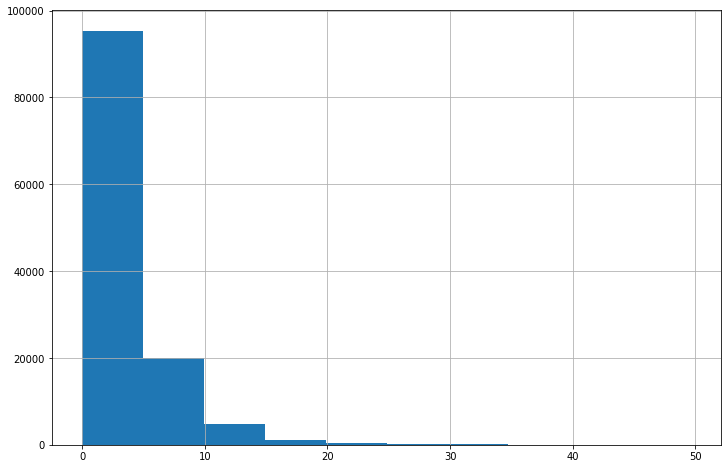

In [59]:
train["microbusiness_density"].hist(figsize=(12,8))

In [60]:
def create_date_features(df):
    df['month'] = df.first_day_of_month.dt.month
    df['day_of_month'] = df.first_day_of_month.dt.day
    df['day_of_year'] = df.first_day_of_month.dt.dayofyear
    df['week_of_year'] = df.first_day_of_month.dt.weekofyear
    df['day_of_week'] = df.first_day_of_month.dt.dayofweek
    df['year'] = df.first_day_of_month.dt.year
    df["is_wknd"] = df.first_day_of_month.dt.weekday // 4
    df['is_month_start'] = df.first_day_of_month.dt.is_month_start.astype(int)
    df['is_month_end'] = df.first_day_of_month.dt.is_month_end.astype(int)
    return df

train = create_date_features(train)
test=create_date_features(test)

In [61]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [62]:
X = train.drop(columns={"row_id", "first_day_of_month", "microbusiness_density", "county", "state", "active"})
y = train["microbusiness_density"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

x_pred = test.drop(columns={"row_id", "first_day_of_month"})

In [ ]:
model = XGBRegressor(n_estimators=7500, eval_metric=smape, early_stopping_rounds=30, learning_rate=0.09)
model.fit(x_train, y_train,  
             eval_set=[(x_valid, y_valid)],
             verbose=100)

y_pred = model.predict(x_pred)

[0]	validation_0-rmse:4.44924	validation_0-smape:107.99035
[100]	validation_0-rmse:1.08589	validation_0-smape:21.79756
[200]	validation_0-rmse:0.81362	validation_0-smape:16.23531
[300]	validation_0-rmse:0.68639	validation_0-smape:12.49185
[400]	validation_0-rmse:0.61328	validation_0-smape:10.14258
[500]	validation_0-rmse:0.56210	validation_0-smape:8.59820
[600]	validation_0-rmse:0.54013	validation_0-smape:7.58589
[700]	validation_0-rmse:0.52297	validation_0-smape:6.89851
[800]	validation_0-rmse:0.50805	validation_0-smape:6.36228
[900]	validation_0-rmse:0.49553	validation_0-smape:5.96502
[1000]	validation_0-rmse:0.48798	validation_0-smape:5.67795
[1100]	validation_0-rmse:0.48093	validation_0-smape:5.46678
[1200]	validation_0-rmse:0.47448	validation_0-smape:5.23711
[1300]	validation_0-rmse:0.46845	validation_0-smape:5.06201
[1400]	validation_0-rmse:0.46400	validation_0-smape:4.89987
[1500]	validation_0-rmse:0.46208	validation_0-smape:4.75990
[1600]	validation_0-rmse:0.46081	validation_0-

In [ ]:
test["microbusiness_density"] = pd.Series(y_pred).astype(float)
test[["row_id", "microbusiness_density"]].to_csv("submission.csv", index=False)